Creación de nuevas variables o transformación las existentes para poder dar mejor respuesta a nuestro objetivo.

# SET UP

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa

#Desactivar la notación científica
pd.options.display.float_format = '{:.2f}'.format

# CARGA DE DATOS

In [64]:
con = sa.create_engine('sqlite:///Datos/airbnb.db')

df = pd.read_sql('df', con=con)
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.46,-3.68,Private room,60,...,t,2,1.00,1.00,80,4.87,4.89,4.77,5098.00,Chamartín
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40,-3.74,Private room,31,...,f,1,1.00,1.00,33,4.58,4.82,4.21,2267.00,Latina
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.39,-3.70,Entire home/apt,50,...,f,6,3.00,5.00,0,NaN,NaN,NaN,4085.00,Arganzuela
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42,-3.71,Entire home/apt,92,...,f,3,1.00,1.00,12,4.92,5.00,5.00,4827.00,Centro
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.39,-3.69,Private room,26,...,f,1,1.00,1.00,149,4.68,4.71,4.70,4085.00,Arganzuela


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17710 entries, 0 to 17709
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           17710 non-null  int64  
 1   id                              17710 non-null  int64  
 2   name                            17707 non-null  object 
 3   host_id                         17710 non-null  int64  
 4   neighbourhood_group             17710 non-null  object 
 5   neighbourhood                   17710 non-null  object 
 6   latitude                        17710 non-null  float64
 7   longitude                       17710 non-null  float64
 8   room_type                       17710 non-null  object 
 9   price                           17710 non-null  int64  
 10  minimum_nights                  17710 non-null  int64  
 11  calculated_host_listings_count  17710 non-null  int64  
 12  availability_365                

# PREPARACIÓN DE VARIABLES

## Creación de KPI'S

Primero se crearán las variables de análisis, las cuales se habían identificado como influyentes sobre el negocio:
- **Precio por noche**: la podemos obtener directamente en la variable `price`, pero habrá que revisarla. Porque no sabemos a que hace referencia este precio, si ese precio es siempre el precio del inmueble o si es un precio por habitación, o si depende del inmueble.
- **Ocupación**: tenemos `availability_365` pero hay que revisar si realizar alguna transformación.
- **Precio del inmueble**: esta variable la tenemos que crear con variables externas

#### Precio por noche

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Filtraremos por solo un distrito para no incluir el efecto "zona".

In [66]:
# Elegir el distrito con mayor número de datos
df.distrito.value_counts()

distrito
Centro                   8127
Salamanca                1218
Chamberí                 1089
Arganzuela               1005
Tetuán                    762
Retiro                    618
Carabanchel               581
Chamartín                 538
Ciudad Lineal             532
Moncloa - Aravaca         493
Puente de Vallecas        465
San Blas - Canillejas     463
Latina                    455
Hortaleza                 354
Fuencarral - El Pardo     265
Usera                     233
Barajas                   142
Villaverde                129
Moratalaz                  94
Villa de Vallecas          90
Vicálvaro                  57
Name: count, dtype: int64

In [67]:
# Comporbamos el precio medio por tipo de alojamiento en el distrito Centro
df.loc[df.distrito=='Centro'].groupby('room_type').price.mean()

room_type
Entire home/apt   148.86
Private room       67.13
Shared room        60.46
Name: price, dtype: float64

**Observaciones:**
* Alquilar el apartamento tiene un precio medio de 148€.
* Alquilar una habitación tiene un precio medio de 60€ o 67€ según sea compartida o privada.

**Para calcular los "ingresos" de un inmueble sí deberemos multiplicar el precio el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room**

Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto deberíamos ponderarlo por el porcentaje medio de habitaciones alquiladas.

No tenemos ese dato, pero supongamos que hemos hablado con el responsable de negocio y nos ha dicho que es del 70%.

**NOTA**: habría que definir también con el responsable de negocio si el calculo del precio por noche se realiza en función del número de camas o en función del númer de habitaciones. Para este caso se utilizará el número de camas dado que existe el concepto de habitación compartida

In [68]:
df.beds.value_counts(dropna=False).sort_index()

beds
0.00      577
1.00     8114
2.00     4703
3.00     2249
4.00     1178
5.00      463
6.00      206
7.00       77
8.00       66
9.00       20
10.00      25
11.00       6
12.00       4
13.00       4
14.00       6
15.00       1
16.00       5
17.00       2
18.00       2
23.00       1
24.00       1
Name: count, dtype: int64

In [69]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [70]:
# Función para calcular el precio total con porcentaje medio de habitaciones alquiladas
def precio_total(registro):
    if (registro.beds > 1) & ((registro.room_type == 'Private room') |  (registro.room_type == 'Shared room')):
        salida = registro.price * registro.beds * 0.7
    else:
        salida = registro.price
    return salida

In [71]:
df['total_price'] = df.apply(precio_total, axis=1)

In [72]:
# Comprobamos los resultados
df[['room_type', 'price', 'beds', 'total_price']].head(20)

,room_type,price,beds,total_price
0,Private room,60,1.00,60.00
1,Private room,31,1.00,31.00
2,Entire home/apt,50,5.00,50.00
3,Entire home/apt,92,1.00,92.00
4,Private room,26,1.00,26.00
5,Entire home/apt,85,3.00,85.00
6,Entire home/apt,65,2.00,65.00
7,Entire home/apt,54,1.00,54.00
8,Entire home/apt,1400,3.00,1400.00
9,Entire home/apt,81,2.00,81.00


### Ocupación

La variable que tenemos que nos permite medir esto es `availability_365`.

Esta variable nos dice el número de días a un año vista que el inmueble NO está ocupado.

Por tanto nos interesaría transformarla a una medida más directa de ocupación, por ejemplo el % del año que SI está ocupada.

In [73]:
# Calculamos la ocupación
df['ocupacion'] = ((365-df.availability_365)/365*100).astype('int')

# Transformamos la salida como un 'int' para redondar el porcentaje

In [74]:
df.ocupacion

0        50
1         0
2        39
3        68
4         4
         ..
17705     1
17706     1
17707     1
17708     1
17709     1
Name: ocupacion, Length: 17710, dtype: int64

## Transformación de variables para el análisis

Algunas de las preguntas de negocio están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Normalmente podremos hacer mejor estos análisis si discretizamos la variable de análisis.

En nuestro caso las candidatas para este análisis son: `accommodates`, `bedrooms`, `beds` y `number_of_reviews`.

En bedrooms tiene sentido una discretización más personalizada. En las otras podemos hacerla automática.

#### Discretizar `bedrooms`

<Axes: xlabel='bedrooms'>

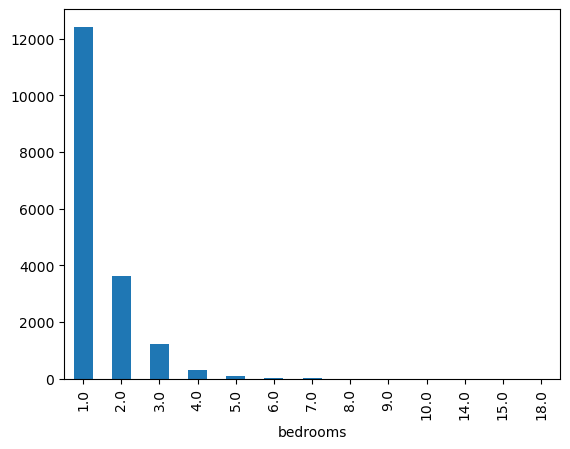

In [75]:
df.bedrooms.value_counts().plot.bar()

Discretizamos utilizando 1,2,3 y 4 o más

In [76]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]

valores = ['01_Una', '02_Dos', '03_Tres', '04_Cuatro o más']

df['bedrooms_disc'] = np.select(condiciones, valores, default='-999')



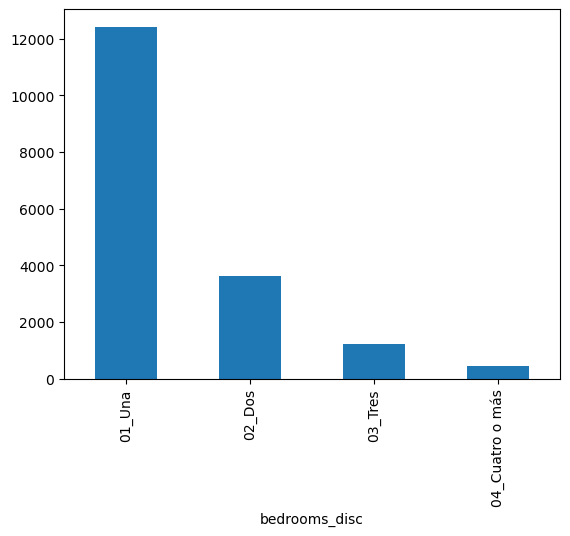

In [77]:
df.bedrooms_disc.value_counts().plot.bar();

#### Discreitzar `accommodates`

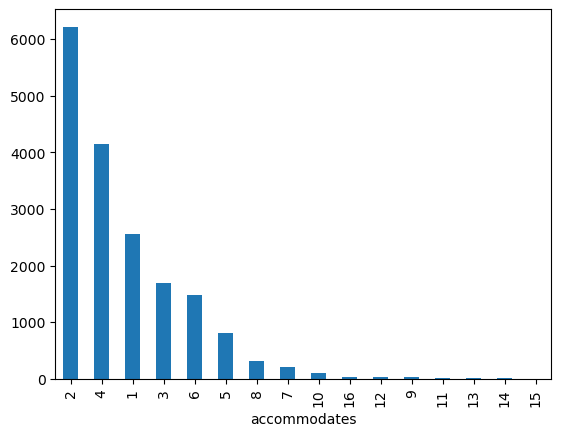

In [78]:
df.accommodates.value_counts().plot.bar();

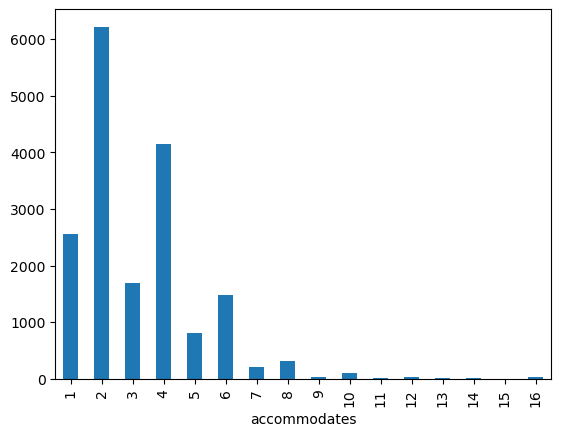

In [79]:
df.accommodates.value_counts().sort_index().plot.bar();

In [101]:
df ['accommodates_disc'] = pd.qcut(df.accommodates, [0, 0.5, 0.8, 1],
        labels=['0-3','4','5-16'])

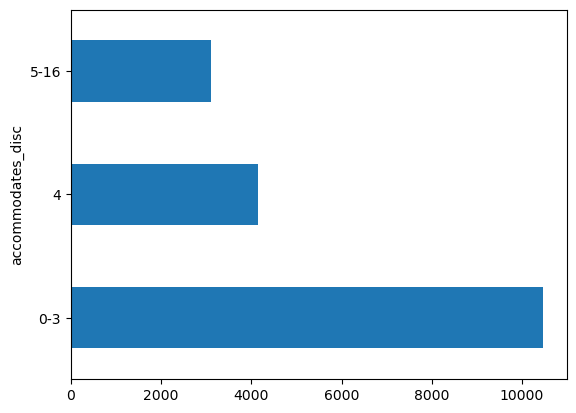

In [103]:
df ['accommodates_disc'].value_counts().plot.barh();

#### Discreitzar `beds`

In [81]:
df.beds.value_counts().sort_index()

beds
0.00      577
1.00     8114
2.00     4703
3.00     2249
4.00     1178
5.00      463
6.00      206
7.00       77
8.00       66
9.00       20
10.00      25
11.00       6
12.00       4
13.00       4
14.00       6
15.00       1
16.00       5
17.00       2
18.00       2
23.00       1
24.00       1
Name: count, dtype: int64

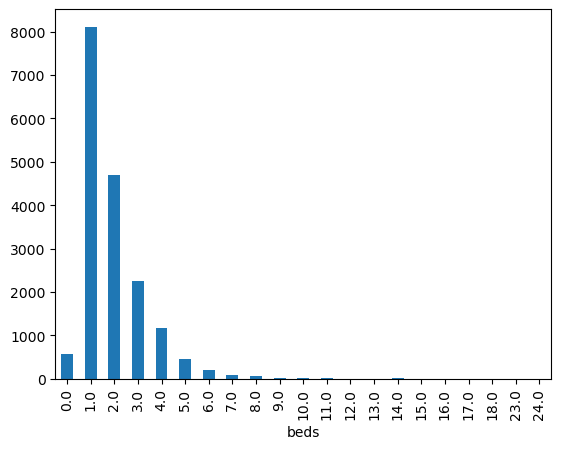

In [82]:
df.beds.value_counts().sort_index().plot.bar();

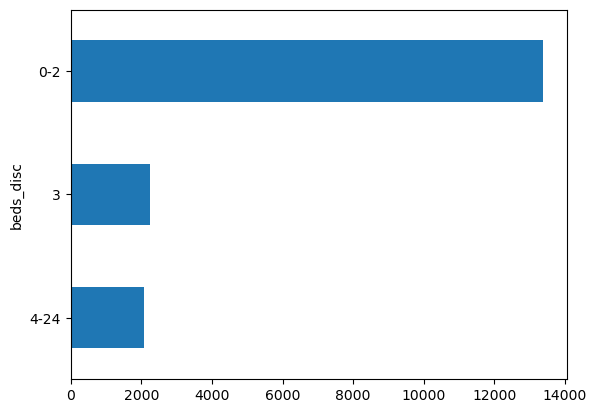

In [83]:
df['beds_disc'] = pd.qcut(df.beds, [0,0.5,0.8,1], 
                          labels = ['0-2','3','4-24'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh();

#### Discreitzar `number_of_reviews`

In [84]:
df.number_of_reviews.value_counts()

number_of_reviews
0      4626
1      1656
2       943
3       701
4       505
       ... 
334       1
468       1
381       1
234       1
392       1
Name: count, Length: 444, dtype: int64

<Axes: xlabel='number_of_reviews'>

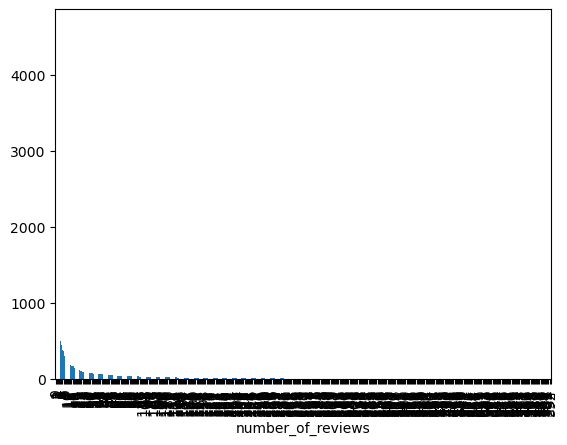

In [85]:
df.number_of_reviews.value_counts().plot.bar()

<Axes: xlabel='number_of_reviews'>

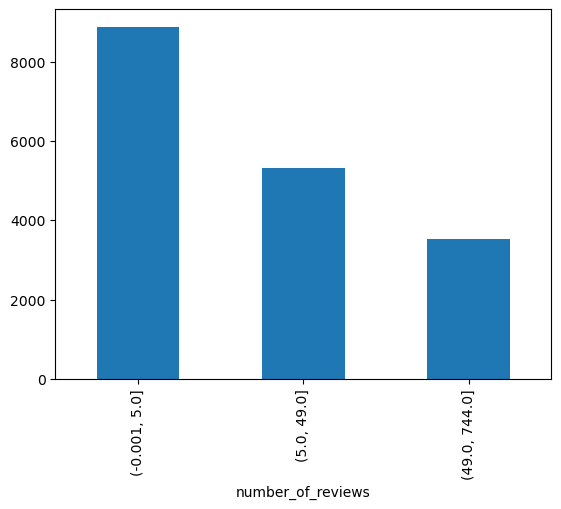

In [86]:
pd.qcut(df.number_of_reviews, [0,0.5,0.8,1]).value_counts().plot.bar()

In [87]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews, [0,0.5,0.8,1], labels = ['0-5','6-49','50-744'])

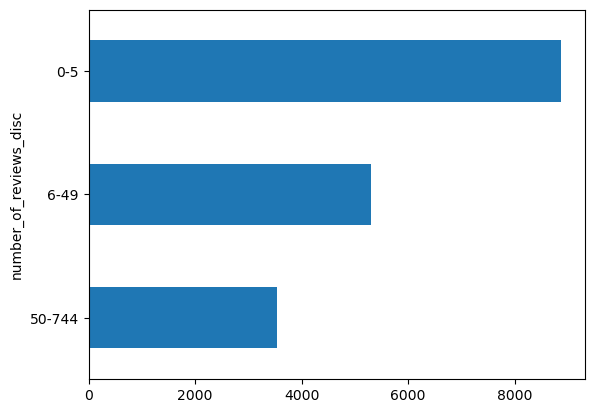

In [88]:
df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh();

## Creación de variables con datos externos

### Estimación m2 del inmueble

Se utilizará el siguiente criterio:

* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120
* cinco o más habitaciones: m2 = 150

In [89]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]

valores = [50, 75, 90, 120, 150]

df['m2'] = np.select(condiciones, valores, default=-999)

In [90]:
df[['bedrooms', 'm2']].head(10)

,bedrooms,m2
0,1.00,50
1,1.00,50
2,3.00,90
3,1.00,50
4,1.00,50
5,3.00,90
6,1.00,50
7,1.00,50
8,2.00,75
9,1.00,50


In [91]:
df.m2.value_counts()

m2
50     12422
75      3617
90      1228
120      296
150      147
Name: count, dtype: int64

### Estimación precio del inmueble

In [92]:
# Asumimos que el equipo de compras puede obtener los inmuebles un 30% más baratos.

df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

### Calcular la distsancia de cada inmueble a la Puerta del Sol

En este caso podríamos hacer mucho con las coordenadas x,y.

Ya que en turismo la localización es muy importante.

Simplemente como ejemplo vamos a calcular la distancia de cada inmueble a la Puerta del Sol.

Para ello buscamos en Google su longitud y latitud: https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitud: 40.4167278 Longitud: -3.7033387


Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con una fórmula que se llama distancia de Haversine.

Una búsqueda en Google nos da una función ya construída para calcularla que podemos adaptar: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [97]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros. Si quieres la distancia en millas, usa 3959.87433
    R = 6372.8

    # Convertir las diferencias de latitud y longitud de grados a radianes
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Fórmula de Haversine para calcular la distancia entre dos puntos en una esfera
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2 * asin(sqrt(a))

    # Distancia final en kilómetros
    return R * c

In [95]:
#Las coordenadas de la Puerta del Sol serán lat1 y lon1
lat1 = 40.4167278
lon1 = -3.7033387


# Necesito definir una función que reciba cada fila del DataFrame y la procese. la función haversine() está definida genéricamente, 
# independiente del dataframe se puede usar en cualquier lugar (otros DataFrames, valores sueltos, etc.).

# Por esto se necesita usar lambda

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

In [96]:
# Comprobamos revisando la distancia media por distritos.
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                   0.73
Arganzuela               1.94
Chamberí                 2.13
Retiro                   2.45
Salamanca                2.72
Moncloa - Aravaca        3.29
Usera                    3.93
Latina                   3.94
Carabanchel              3.97
Chamartín                4.43
Puente de Vallecas       4.48
Tetuán                   4.62
Moratalaz                5.07
Ciudad Lineal            5.23
Villaverde               7.66
Fuencarral - El Pardo    8.06
Hortaleza                8.07
San Blas - Canillejas    8.20
Vicálvaro                8.60
Villa de Vallecas        9.18
Barajas                 11.44
Name: pdi_sol, dtype: float64

# CARGA EN BASE DE DATOS

In [104]:
df.to_sql('df_preparado', con = con, if_exists = 'replace')

17710